In [1]:
import dtale, os, atom, shap
#from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from functools import wraps
import seaborn as sns


import fufu
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
pd.options.display.max_columns = 500 # this will set limit of columns to 500
%matplotlib inline
os.getcwd()

'P:\\Python\\Projetos Python\\Forescast Sales'

# CLASSES

In [2]:
class filtrator(BaseEstimator, TransformerMixin):
    def __init__(self,mapper_in=None,mapper_out=None):
        self.mapper_in=mapper_in
        self.mapper_out=mapper_out
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        if self.mapper_in !=None:
            for k,v in self.mapper_in.items():
                X2=X2[X2[k].isin(v)]
        else: pass
        if self.mapper_out !=None:
            for k,v in self.mapper_out.items():
                X2=X2[~X2[k].isin(v)]
        pass
        return X2

In [3]:
class cols_selector(BaseEstimator, TransformerMixin):
    def __init__(self,sel=None,drop=None):
        self.sel=sel
        self.drop=drop
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        if self.sel !=None:
            X2=X.copy()
            X2=X2[self.sel]
        else:
            X2=X.copy()
            X2=X2.drop(self.drop,axis=1)
        return X2

In [4]:
class dtypes(BaseEstimator, TransformerMixin):
    def __init__(self,dict_cols=None):
        self.dict_cols=dict_cols
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        for k,v in self.dict_cols.items():
            X2[k]=X2[k].astype(v)
        return X2

# IMPORT & EXPLORATION

In [31]:
import zipfile

In [32]:
from kaggle.api.kaggle_api_extended import KaggleApi
import kaggle

api=KaggleApi()
api.authenticate()

In [33]:
os.mkdir("data")

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: 'data'

In [36]:
l=["train.csv","test.csv","oil.csv","holidays_events.csv","stores.csv","transactions.csv"]
for i in l:
    api.competition_download_file("store-sales-time-series-forecasting",i,force=True)

100%|██████████| 20.8M/20.8M [00:02<00:00, 8.36MB/s]


100%|██████████| 998k/998k [00:00<00:00, 9.40MB/s]

100%|██████████| 20.1k/20.1k [00:00<00:00, 2.95MB/s]

100%|██████████| 21.8k/21.8k [00:00<00:00, 770kB/s]

100%|██████████| 1.35k/1.35k [00:00<00:00, 232kB/s]

100%|██████████| 360k/360k [00:00<00:00, 7.12MB/s]

In [1]:
train=pd.read_csv(r"data/train.csv.zip",index_col='id',parse_dates=['date'])
oil=pd.read_csv(r"data/oil.csv")
hol=pd.read_csv(r"data/holidays_events.csv")
stores=pd.read_csv("data/stores.csv")
test=pd.read_csv("data/test.csv",index_col='id',parse_dates=['date'])

NameError: name 'pd' is not defined

In [43]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


In [45]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [46]:
hol.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [47]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [48]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## BASELINE

In [51]:
from sklearn.model_selection import TimeSeriesSplit

In [71]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [83]:
train2=train.set_index('date')
train2.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


In [91]:
train2=train.set_index('date').resample('D').agg({'sales':'sum'})
train2.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


<AxesSubplot:xlabel='date', ylabel='sales'>

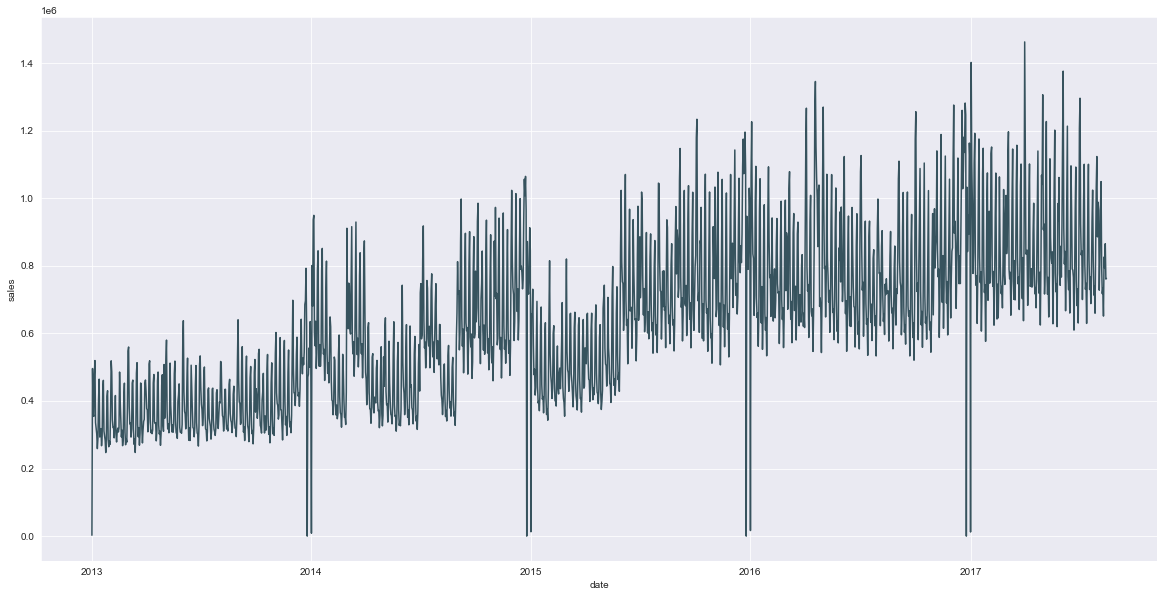

In [96]:
from matplotlib.pyplot import figure

figure(figsize=(20,10))

sns.lineplot(x=train2.index,y=train2['sales'])

In [97]:
X=train.drop('sales',axis=1)
y=train['sales']

tscv = TimeSeriesSplit()
print(tscv)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index,:], X.iloc[test_index,:]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [     0      1      2 ... 500145 500146 500147] TEST: [ 500148  500149  500150 ... 1000293 1000294 1000295]
TRAIN: [      0       1       2 ... 1000293 1000294 1000295] TEST: [1000296 1000297 1000298 ... 1500441 1500442 1500443]
TRAIN: [      0       1       2 ... 1500441 1500442 1500443] TEST: [1500444 1500445 1500446 ... 2000589 2000590 2000591]
TRAIN: [      0       1       2 ... 2000589 2000590 2000591] TEST: [2000592 2000593 2000594 ... 2500737 2500738 2500739]
TRAIN: [      0       1       2 ... 2500737 2500738 2500739] TEST: [2500740 2500741 2500742 ... 3000885 3000886 3000887]


In [98]:
import xgboost

In [101]:
model=xgboost.XGBRegressor()

In [ ]:
seed=42
pipe=atom.ATOMRegressor(df,y='sales',verbose=2,test_size=.2,holdout_size=0.20,stratify=True,random_state=42)
pipe.add(cols_selector(drop=['name','ticket','cabin','passengerid']))
pipe.add(dtypes(dict_cols={'sex':'object','embarked':'object'}))
#pipe.add(filtrator(mapper_in={'sex':'object','embarked':'object',mapper_out=}))
pipe.impute(strat_num='median',strat_cat='most_frequent',max_nan_rows=0.7,verbose=2)
pipe.scale(strategy='standard')
pipe.encode(ordinal=None,max_onehot=5,strategy='Target',verbose=2)
pipe.impute(strat_num=0,verbose=2)
pipe.plot_pipeline()

In [7]:
df=fetch_openml("titanic", version=1, as_frame=True).frame
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (713, 12)
Memory: 258.07 kB
Scaled: False
Missing values: 692 (8.1%)
Categorical features: 5 (45.5%)
Outlier values: 36 (0.6%)
-------------------------------------
Train set size: 535
Test set size: 178
Holdout set size: 178
-------------------------------------
|   |     dataset |       train |        test |
| - | ----------- | ----------- | ----------- |
| 0 |   439 (1.6) |   329 (1.6) |   110 (1.6) |
| 1 |   274 (1.0) |   206 (1.0) |    68 (1.0) |

Fitting cols_selector...
Applying cols_selector to the dataset...
Fitting dtypes...
Applying dtypes to the dataset...
Fitting Imputer...
Imputing missing values...
 --> Imputing 137 missing values with median (28.5) in feature age.
 --> Imputing 2 missing values with most_frequent (S) in feature embarked.
Fitting Scaler...
Scaling features...
Fitting Encoder...
Encoding categorical columns...
 --> Ordinal-

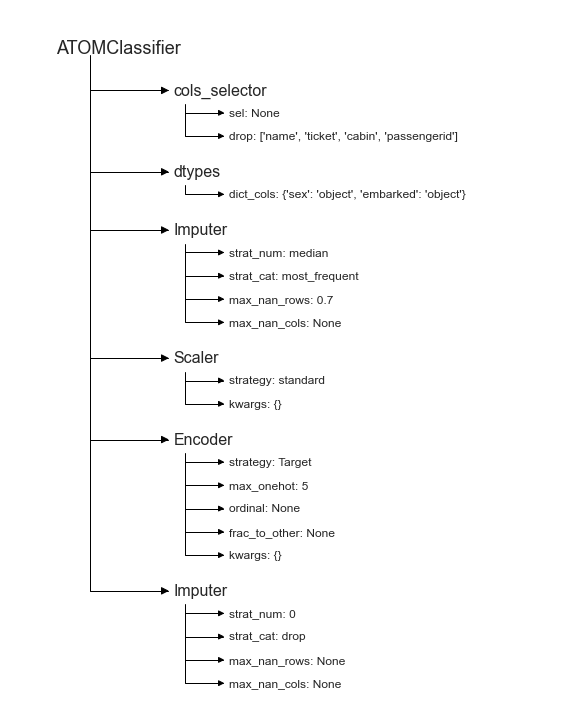

In [10]:
seed=42
pipe=atom.ATOMClassifier(df,y='survived',verbose=2,test_size=.2,holdout_size=0.20,stratify=True,random_state=42)
pipe.add(cols_selector(drop=['name','ticket','cabin','passengerid']))
pipe.add(dtypes(dict_cols={'sex':'object','embarked':'object'}))
#pipe.add(filtrator(mapper_in={'sex':'object','embarked':'object',mapper_out=}))
pipe.impute(strat_num='median',strat_cat='most_frequent',max_nan_rows=0.7,verbose=2)
pipe.scale(strategy='standard')
pipe.encode(ordinal=None,max_onehot=5,strategy='Target',verbose=2)
pipe.impute(strat_num=0,verbose=2)
pipe.plot_pipeline()

## TREINO

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import logging
logging.captureWarnings(True)
pipe.clear()
pipe.run(models=['RFC','XGB','CatB'],n_bootstrap=5,metric=["accuracy"],n_calls=30,bo_params=
         {"dimensions":{"all":"n_estimators","RFC":"max_depth","XGB":"max_depth"}})
#warnings.simplefilter('module')
logging.captureWarnings(False)

2022-05-22 21:57:08,386 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations




Training ========================= >>
Models: RFC, XGB, CatB
Metric: accuracy


Running BO for Random Forest...
| call             | n_estimators | max_depth | accuracy | best_accuracy |    time | total_time |
| ---------------- | ------------ | --------- | -------- | ------------- | ------- | ---------- |


2022-05-22 21:57:09,422 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 1  |          400 |         3 |   0.8134 |        0.8134 |  1.031s |     1.054s |


2022-05-22 21:57:10,417 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 2  |          392 |        10 |   0.8284 |        0.8284 |  0.991s |     2.048s |


2022-05-22 21:57:10,979 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 3  |          228 |         2 |   0.7836 |        0.8284 |  0.557s |     2.611s |


2022-05-22 21:57:11,571 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 4  |          235 |         5 |   0.8881 |        0.8881 |  0.588s |     3.204s |
| Initial point 5  |           80 |        10 |   0.8134 |        0.8881 |  0.304s |     3.512s |


2022-05-22 21:57:12,894 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:13,153 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 6      |          379 |         6 |   0.8284 |        0.8881 |  0.762s |     5.913s |


2022-05-22 21:57:14,739 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:15,819 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 7      |          500 |         5 |   0.8209 |        0.8881 |  0.910s |     7.285s |


2022-05-22 21:57:15,894 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:16,070 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 8      |          179 |         5 |   0.8806 |        0.8881 |  0.440s |     8.146s |


2022-05-22 21:57:16,795 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:17,066 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 9      |          238 |         5 |   0.8507 |        0.8881 |  0.518s |     9.221s |


2022-05-22 21:57:17,942 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:18,087 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 10     |           75 |         5 |   0.9179 |        0.9179 |  0.271s |     9.995s |


2022-05-22 21:57:18,622 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:18,786 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 11     |           10 |         5 |   0.8507 |        0.9179 |  0.172s |    10.593s |


2022-05-22 21:57:19,184 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:19,366 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 12     |           83 |         6 |   0.8284 |        0.9179 |  0.280s |    11.284s |


2022-05-22 21:57:19,858 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:20,065 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 13     |           25 |         4 |   0.8507 |        0.9179 |  0.182s |    11.882s |


2022-05-22 21:57:20,484 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:20,607 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 14     |           99 |         5 |   0.8657 |        0.9179 |  0.325s |    12.569s |


2022-05-22 21:57:21,230 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:21,391 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 15     |          499 |        16 |   0.8433 |        0.9179 |  0.967s |    13.995s |


2022-05-22 21:57:22,653 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:22,790 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 16     |           10 |        14 |   0.8582 |        0.9179 |  0.171s |    14.598s |


2022-05-22 21:57:23,236 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:23,393 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 17     |          283 |        13 |   0.8134 |        0.9179 |  0.706s |    15.736s |


2022-05-22 21:57:24,318 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:24,406 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 18     |           10 |        15 |    0.806 |        0.9179 |  0.203s |    16.453s |


2022-05-22 21:57:25,112 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:25,323 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 19     |          399 |        14 |   0.7612 |        0.9179 |  1.141s |    18.100s |


2022-05-22 21:57:26,693 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:26,780 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 20     |          128 |         5 |   0.8881 |        0.9179 |  0.424s |    19.040s |


2022-05-22 21:57:27,705 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:27,940 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 21     |          500 |      None |   0.8134 |        0.9179 |  1.163s |    20.740s |


2022-05-22 21:57:29,363 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:29,586 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 22     |          134 |         5 |   0.8507 |        0.9179 |  0.619s |    21.842s |


2022-05-22 21:57:30,465 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:30,705 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 23     |          136 |         5 |    0.806 |        0.9179 |  0.474s |    22.816s |


2022-05-22 21:57:31,452 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:31,635 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 24     |          497 |         8 |   0.8284 |        0.9179 |  0.938s |    24.209s |


2022-05-22 21:57:32,957 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:32,958 - WARNING  - The objective has been evaluated at this point before.

2022-05-22 21:57:33,095 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

| Iteration 25     |           10 |         5 |   0.8507 |        0.9179 |  0.001s |    24.595s |


2022-05-22 21:57:33,175 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:33,512 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 26     |           78 |         5 |   0.8209 |        0.9179 |  0.321s |    25.470s |


2022-05-22 21:57:34,209 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:34,469 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 27     |          161 |         4 |   0.7985 |        0.9179 |  0.451s |    26.557s |


2022-05-22 21:57:35,159 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:35,420 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 28     |           11 |        16 |   0.7537 |        0.9179 |  0.199s |    27.256s |


2022-05-22 21:57:35,903 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:36,110 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 29     |          186 |         5 |   0.8507 |        0.9179 |  0.422s |    28.168s |


2022-05-22 21:57:37,059 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:37,469 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 30     |           71 |         5 |   0.8507 |        0.9179 |  0.235s |    28.931s |


2022-05-22 21:57:37,539 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:37,762 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

Bayesian Optimization ---------------------------
Best call --> Iteration 10
Best parameters --> {'n_estimators': 75, 'max_depth': 5}
Best evaluation --> accuracy: 0.9179
Time elapsed: 29.401s
Fit ---------------------------------------------


2022-05-22 21:57:38,654 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:38,709 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Train evaluation --> accuracy: 0.8673
Test evaluation --> accuracy: 0.809
Time elapsed: 0.208s
Bootstrap ---------------------------------------
Evaluation --> accuracy: 0.8124 ± 0.0084
Time elapsed: 0.664s
-------------------------------------------------
Total time: 30.274s


Running BO for XGBoost...
| call             | n_estimators | max_depth | accuracy | best_accuracy |    time | total_time |
| ---------------- | ------------ | --------- | -------- | ------------- | ------- | ---------- |


2022-05-22 21:57:39,624 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:39,930 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:40,086 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



| Initial point 1  |          402 |         4 |   0.8582 |        0.8582 |  1.273s |     1.289s |


2022-05-22 21:57:40,491 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 2  |          394 |        12 |   0.7687 |        0.8582 |  0.553s |     1.845s |


2022-05-22 21:57:40,687 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:40,869 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:41,017 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



| Initial point 3  |          234 |         3 |   0.7836 |        0.8582 |  0.374s |     2.227s |


2022-05-22 21:57:41,254 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:41,415 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



| Initial point 4  |          240 |         7 |   0.8582 |        0.8582 |  0.381s |     2.612s |


2022-05-22 21:57:41,666 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:41,687 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Initial point 5  |           89 |        13 |   0.7687 |        0.8582 |  0.288s |     2.905s |


2022-05-22 21:57:41,806 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:42,009 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:42,641 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 6      |          500 |         6 |   0.8358 |        0.8582 |  0.643s |     3.811s |


2022-05-22 21:57:42,663 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:42,800 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 7      |           20 |         8 |   0.7836 |        0.8582 |  0.234s |     4.397s |


2022-05-22 21:57:43,289 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:43,521 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:43,720 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 8      |           20 |         5 |   0.8731 |        0.8731 |  0.278s |     4.929s |


2022-05-22 21:57:43,880 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:44,062 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:44,666 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 9      |          499 |         5 |   0.8433 |        0.8731 |  0.663s |     5.906s |


2022-05-22 21:57:44,900 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:45,412 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:45,434 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 10     |          499 |        20 |   0.8507 |        0.8731 |  0.549s |     6.653s |


2022-05-22 21:57:45,565 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:45,718 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:46,299 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 11     |          498 |        18 |   0.8358 |        0.8731 |  0.555s |     7.482s |


2022-05-22 21:57:46,401 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:46,562 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:46,791 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 12     |           20 |        20 |   0.7836 |        0.8731 |  0.198s |     7.961s |


2022-05-22 21:57:46,828 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:47,065 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 13     |           20 |         4 |   0.8358 |        0.8731 |  0.172s |     8.599s |


2022-05-22 21:57:47,609 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:47,768 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:47,994 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 14     |           88 |         5 |   0.8731 |        0.8731 |  0.238s |     9.208s |


2022-05-22 21:57:48,230 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:48,376 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:48,563 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 15     |           20 |         6 |   0.8582 |        0.8731 |  0.175s |     9.767s |


2022-05-22 21:57:48,843 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:48,990 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:49,577 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 16     |          500 |        16 |   0.8284 |        0.8731 |  0.542s |    10.747s |


2022-05-22 21:57:49,726 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:49,924 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 17     |           20 |        17 |   0.7537 |        0.8731 |  0.183s |    11.468s |


2022-05-22 21:57:50,507 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:50,643 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:51,013 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 18     |          260 |         6 |   0.8284 |        0.8731 |  0.345s |    12.213s |


2022-05-22 21:57:51,323 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:51,503 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:51,870 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 19     |          482 |         2 |   0.7313 |        0.8731 |  0.405s |    13.090s |


2022-05-22 21:57:52,125 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:52,279 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:52,795 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 20     |          500 |         7 |    0.806 |        0.8731 |  0.554s |    14.042s |


2022-05-22 21:57:53,127 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:53,293 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:53,621 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 21     |          200 |         5 |   0.7612 |        0.8731 |  0.338s |    14.827s |


2022-05-22 21:57:53,877 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:54,033 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:54,243 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 22     |           53 |         5 |   0.8433 |        0.8731 |  0.205s |    15.444s |


2022-05-22 21:57:54,598 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:54,749 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:57:54,989 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

| Iteration 23     |           99 |         5 |   0.7388 |        0.8731 |  0.237s |    16.197s |


2022-05-22 21:57:55,439 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:55,632 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



| Iteration 24     |           85 |         5 |   0.7761 |        0.8731 |  0.276s |    17.079s |


2022-05-22 21:57:55,961 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:55,994 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 25     |           24 |         4 |   0.8284 |        0.8731 |  0.216s |    18.010s |


2022-05-22 21:57:56,878 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:56,913 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 26     |          243 |         9 |   0.8433 |        0.8731 |  0.388s |    19.049s |


2022-05-22 21:57:57,933 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:58,338 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 27     |          404 |         2 |   0.7687 |        0.8731 |  0.370s |    20.070s |


2022-05-22 21:57:58,927 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:59,285 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 28     |          244 |         7 |   0.7388 |        0.8731 |  0.396s |    21.044s |


2022-05-22 21:57:59,950 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:57:59,977 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 29     |           20 |         2 |   0.8433 |        0.8731 |  0.178s |    21.737s |


2022-05-22 21:58:00,753 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:00,927 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



| Iteration 30     |           24 |         1 |    0.806 |        0.8731 |  0.194s |    22.309s |


2022-05-22 21:58:01,164 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:01,183 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

Bayesian Optimization ---------------------------
Best call --> Iteration 8
Best parameters --> {'n_estimators': 20, 'max_depth': 5}
Best evaluation --> accuracy: 0.8731
Time elapsed: 22.740s
Fit ---------------------------------------------
Train evaluation --> accuracy: 0.914
Test evaluation --> accuracy: 0.8034
Time elapsed: 0.070s


2022-05-22 21:58:01,606 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:58:01,627 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:58:01,645 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:58:01,665 - WARNING  - pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

2022-05-22 21:58:01,682 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If yo

Bootstrap ---------------------------------------
Evaluation --> accuracy: 0.8101 ± 0.0125
Time elapsed: 0.219s
-------------------------------------------------
Total time: 23.032s


Running BO for CatBoost...
| call             | n_estimators | accuracy | best_accuracy |    time | total_time |
| ---------------- | ------------ | -------- | ------------- | ------- | ---------- |


2022-05-22 21:58:04,421 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 1  |          402 |   0.8507 |        0.8507 |  2.737s |     2.749s |


2022-05-22 21:58:04,654 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 2  |          108 |   0.8731 |        0.8731 |  0.226s |     2.978s |


2022-05-22 21:58:05,206 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 3  |          394 |   0.8358 |        0.8731 |  0.550s |     3.533s |


2022-05-22 21:58:05,655 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Initial point 4  |          306 |   0.8657 |        0.8731 |  0.445s |     3.982s |


2022-05-22 21:58:06,192 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:06,207 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Initial point 5  |          234 |   0.8358 |        0.8731 |  0.375s |     4.361s |


2022-05-22 21:58:06,294 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:06,641 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 6      |          102 |   0.8358 |        0.8731 |  0.259s |     4.883s |


2022-05-22 21:58:07,067 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



| Iteration 7      |          109 |    0.806 |        0.8731 |  0.257s |     5.292s |


2022-05-22 21:58:07,210 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:07,269 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 8      |          306 |   0.8657 |        0.8731 |  0.001s |     5.602s |


2022-05-22 21:58:08,064 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:08,078 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 9      |          325 |   0.8582 |        0.8731 |  0.492s |     6.294s |


2022-05-22 21:58:08,696 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:08,711 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 10     |          283 |    0.903 |         0.903 |  0.454s |     6.919s |


2022-05-22 21:58:09,317 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:09,331 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 11     |          272 |   0.8582 |         0.903 |  0.442s |     7.537s |


2022-05-22 21:58:10,205 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:10,219 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 12     |          500 |   0.7985 |         0.903 |  0.673s |     8.397s |


2022-05-22 21:58:10,290 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:10,831 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 13     |          288 |   0.8657 |         0.903 |  0.439s |     9.059s |


2022-05-22 21:58:11,443 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:11,458 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 14     |          287 |   0.8731 |         0.903 |  0.438s |     9.682s |


2022-05-22 21:58:12,184 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:12,201 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 15     |          285 |   0.8657 |         0.903 |  0.534s |    10.408s |


2022-05-22 21:58:12,307 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:12,630 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 16     |           20 |   0.8433 |         0.903 |  0.214s |    10.853s |


2022-05-22 21:58:12,774 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:13,305 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 17     |          176 |   0.8284 |         0.903 |  0.423s |    11.529s |


2022-05-22 21:58:13,450 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:14,141 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 18     |          349 |   0.8433 |         0.903 |  0.585s |    12.366s |


2022-05-22 21:58:14,272 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:14,620 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 19     |           52 |   0.8209 |         0.903 |  0.250s |    12.851s |


2022-05-22 21:58:14,774 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:15,408 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 20     |          286 |   0.8806 |         0.903 |  0.541s |    13.645s |


2022-05-22 21:58:15,572 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:16,367 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 21     |          444 |   0.8209 |         0.903 |  0.703s |    14.605s |


2022-05-22 21:58:16,503 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:17,032 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 22     |          240 |   0.8284 |         0.903 |  0.438s |    15.271s |


2022-05-22 21:58:17,242 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:17,828 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 23     |          294 |   0.8134 |         0.903 |  0.492s |    16.065s |


2022-05-22 21:58:18,008 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:18,566 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 24     |          280 |   0.8433 |         0.903 |  0.445s |    16.784s |


2022-05-22 21:58:18,708 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:18,898 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 25     |          314 |   0.8358 |         0.903 |  0.501s |    17.729s |


2022-05-22 21:58:19,652 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:20,023 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 26     |          156 |   0.8358 |         0.903 |  0.277s |    18.259s |


2022-05-22 21:58:20,193 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:20,817 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 27     |          334 |   0.7985 |         0.903 |  0.499s |    19.022s |


2022-05-22 21:58:21,001 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:21,614 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 28     |          284 |   0.7687 |         0.903 |  0.508s |    19.839s |


2022-05-22 21:58:21,802 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:22,280 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 29     |          204 |   0.8731 |         0.903 |  0.389s |    20.521s |


2022-05-22 21:58:22,471 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

2022-05-22 21:58:22,936 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

| Iteration 30     |          206 |   0.8507 |         0.903 |  0.378s |    21.180s |


2022-05-22 21:58:23,170 - WARNING  - `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Bayesian Optimization ---------------------------
Best call --> Iteration 10
Best parameters --> {'n_estimators': 283}
Best evaluation --> accuracy: 0.903
Time elapsed: 21.503s
Fit ---------------------------------------------
Train evaluation --> accuracy: 0.8692
Test evaluation --> accuracy: 0.809
Time elapsed: 0.390s
Bootstrap ---------------------------------------
Evaluation --> accuracy: 0.8135 ± 0.0075
Time elapsed: 1.487s
-------------------------------------------------
Total time: 23.382s


Final results ==================== >>
Duration: 1m:17s
-------------------------------------
Random Forest --> accuracy: 0.8124 ± 0.0084
XGBoost       --> accuracy: 0.8101 ± 0.0125
CatBoost      --> accuracy: 0.8135 ± 0.0075 !


In [15]:
results=[]
for i in ['train','test','holdout']:
    df0=pipe.evaluate(dataset=i)
    df0['type']=i
    results.append(df0)
results=pd.concat(results)
results=results.sort_index()
logging.captureWarnings(False)
results

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Applying cols_selector to the dataset...
Applying dtypes to the dataset...


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,accuracy,average_precision,balanced_accuracy,f1,jaccard,matthews_corrcoef,precision,recall,roc_auc,type
CatB,0.869159,0.923876,0.841894,0.809783,0.680365,0.724170,0.919753,0.723301,0.936155,train
CatB,0.808989,0.838594,0.769652,0.706897,0.546667,0.590463,0.854167,0.602941,0.870989,test
CatB,0.814607,0.830210,0.774198,0.713043,0.554054,0.604450,0.872340,0.602941,0.847660,holdout
RFC,0.867290,0.918525,0.839466,0.806540,0.675799,0.720294,0.919255,0.718447,0.928778,train
RFC,0.808989,0.838243,0.769652,0.706897,0.546667,0.590463,0.854167,0.602941,0.873797,test
RFC,0.803371,0.796485,0.759492,0.690265,0.527027,0.580193,0.866667,0.573529,0.845789,holdout
XGB,0.914019,0.962828,0.898331,0.881443,0.788018,0.818244,0.939560,0.830097,0.972755,train
XGB,0.803371,0.821521,0.770722,0.710744,0.551282,0.575322,0.811321,0.632353,0.851337,test
XGB,0.808989,0.774120,0.778075,0.721311,0.564103,0.587807,0.814815,0.647059,0.825401,holdout


                     RFC       XGB      CatB
metric_bo        0.91791  0.873134  0.902985
time_bo          29.401s   22.740s   21.503s
metric_train     0.86729  0.914019  0.869159
metric_test     0.808989  0.803371  0.808989
time_fit          0.208s    0.070s    0.390s
mean_bootstrap   0.81236  0.810112  0.813483
std_bootstrap   0.008408  0.012512  0.007453
time_bootstrap    0.664s    0.219s    1.487s
time             30.274s   23.032s   23.382s


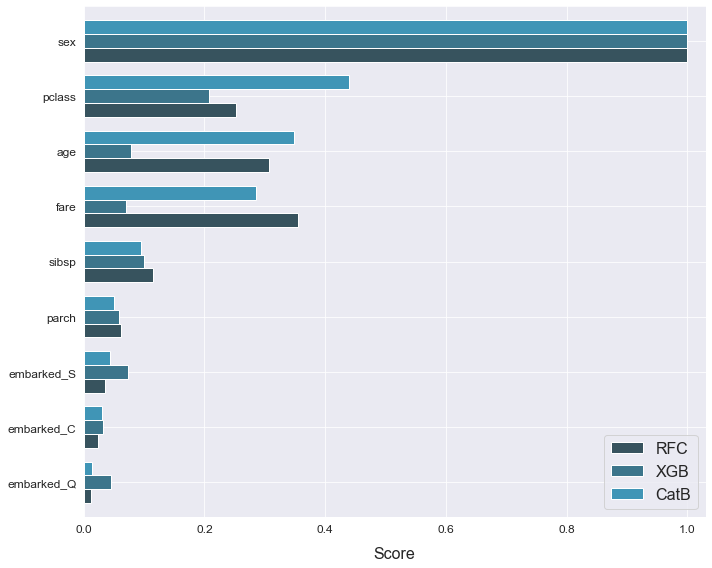

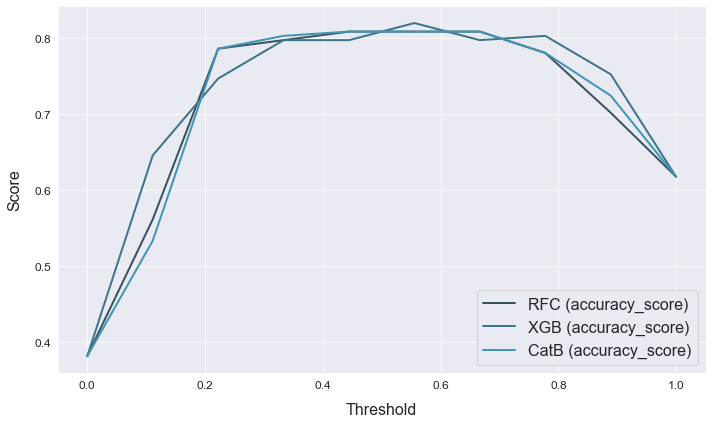

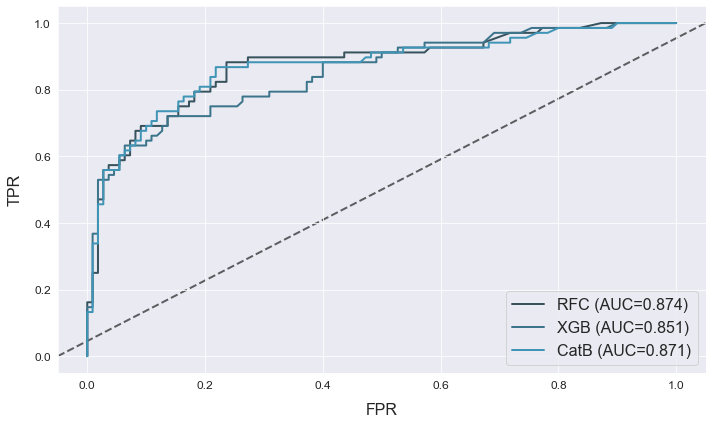

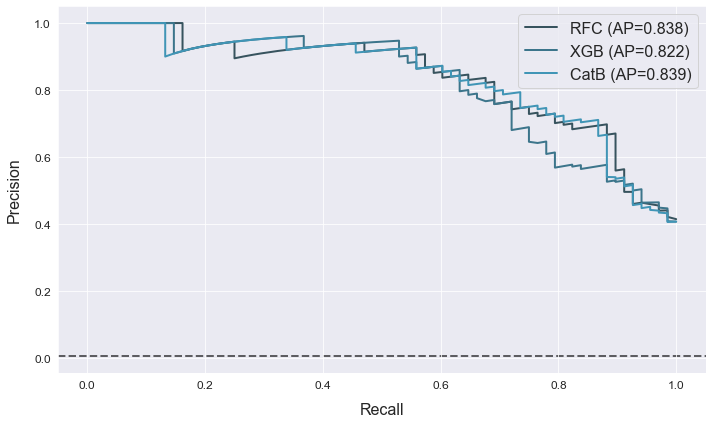

unclosed file <_io.BufferedRandom name=5>


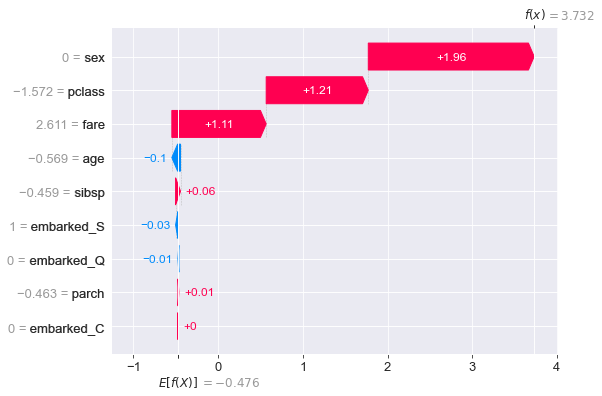

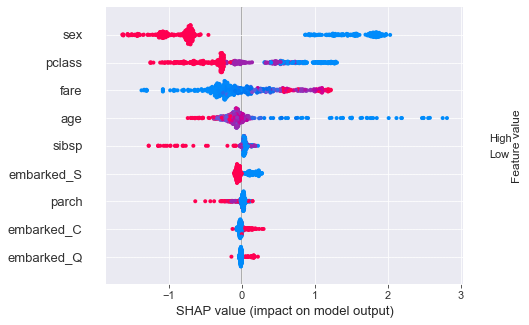

In [16]:
%matplotlib inline
X=pipe.train.iloc[:,:-1]
print(pipe.results.transpose())
pipe.plot_feature_importance()
pipe.plot_threshold(metric=["accuracy"], steps=10)
pipe.plot_roc()
pipe.plot_prc()
explainer = shap.Explainer(pipe._models['CatB'].estimator)
shap_values=explainer(X)
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)

In [17]:
pl = pipe.export_pipeline(model="CatB")
print(pl)

Pipeline(steps=[('cols_selector',
                 cols_selector(drop=['name', 'ticket', 'cabin',
                                     'passengerid'])),
                ('dtypes',
                 dtypes(dict_cols={'embarked': 'object', 'sex': 'object'})),
                ('imputer',
                 Imputer(max_nan_rows=0.7, strat_cat='most_frequent',
                         strat_num='median', verbose=2)),
                ('scaler', Scaler(verbose=2)),
                ('encoder',
                 Encoder(max_onehot=5, strategy='Target', verbose=2)),
                ('imputer2', Imputer(strat_num=0, verbose=2)),
                ('CatB',
                 <catboost.core.CatBoostClassifier object at 0x000001F48AE9CA30>)])


In [93]:
test=pd.read_csv(R"P:\Python\Projetos Python\Titanic\test.csv")
test.columns=test.columns.str.lower()
test.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [94]:
y_pred=pl.predict(test)
y_pred2=pd.concat([test['passengerid'],pd.Series(y_pred)],axis=1).rename(columns={0:'Survived'})
y_pred2.head()

Imputing missing values...
 --> Imputing 86 missing values with median (28.5) in feature age.
 --> Imputing 1 missing values with median (14.45) in feature fare.
Scaling features...
Encoding categorical columns...
 --> Ordinal-encoding feature sex. Contains 2 classes.
 --> OneHot-encoding feature embarked. Contains 3 classes.
Imputing missing values...


,passengerid,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [78]:
y_pred2.to_csv("sample.csv",index=False)